# 1.0 Model : SRCNN w/o Data Augmentation

Let's replicate SRCNN architecture from paper https://arxiv.org/pdf/1501.00092.pdf

## 1.1 SRCNN Model(9-x-5) Class

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL

/home/mpershad/Documents/Python/SRCNN_DIV2K/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%capture
try:
    import wandb
    import yaml
    import torchinfo
except:
    %pip install wandb
    %pip install pyyaml
    %pip install torchinfo
    import yaml
    import wandb
    import torchinfo

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import os
import yaml
import torch
import torch.nn as nn
import torch.nn.init as init
import wandb
from glob import glob

class SRCNN(nn.Module):
    """
    Model architecture (9-x-5) from original paper.
    """

    def __init__(self, input_channels: int, hidden_units_1: int, hidden_units_2: int, kernel_sizes: list, padding: str, output_channels: int, run_id: str = None, device: str = 'cpu') -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units_1, kernel_size=kernel_sizes[0], padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units_1, out_channels=hidden_units_2, kernel_size=kernel_sizes[1], padding=padding),
            nn.ReLU()
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units_2, out_channels=output_channels, kernel_size=kernel_sizes[2], padding=padding)
        )
        self._initialize_weights()

        if run_id is not None:
            self.load_model_from_wandb(run_id=run_id, device=device)

    def _initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                init.normal_(layer.weight, mean=0.0, std=0.001)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x

    @classmethod
    def load_model_from_wandb(cls, run_id: str, artifact_id:str , device: str = 'cpu'):
        # Set up W&B
        wandb.login()
        api = wandb.Api()

        # Download the config.yaml file
        run = api.run(f"{entity_name}/{project_name}/{run_id}")
        config_file = run.file("config.yaml").download(replace=True)
        
        # Load the configuration
        with open(config_file.name, 'r') as file:
            config_data = yaml.safe_load(file)

        config = {k: v['value'] if isinstance(v, dict) and 'value' in v else v for k, v in config_data.items()}

        # Extract model-specific configuration values
        config_keys = ['input_channels', 'hidden_units_1', 'hidden_units_2', 'kernel_sizes', 'padding', 'output_channels']
        config = {k: v['value'] if isinstance(v, dict) and 'value' in v else v for k, v in config_data.items() if k in config_keys}

        # Instantiate the model with loaded configuration
        model = cls(**config, device=device)

        # Download and load the model checkpoint
        artifact = api.artifact(artifact_id, type="model")
        artifact_dir = artifact.download()
        model_path = glob(os.path.join(artifact_dir, "*.pth"))[0]
        checkpoint = torch.load(model_path, map_location=device)

        model.load_state_dict(checkpoint['model_state_dict'])

        return model
    
    # Load model present locally along with config file
    @classmethod
    def load_model(cls, model_path: str, config_path: str, device: str = 'cpu'):
        # Load the configuration
        with open(config_path, 'r') as file:
            config_data = yaml.safe_load(file)

        config = {k: v['value'] if isinstance(v, dict) and 'value' in v else v for k, v in config_data.items()}

        # Extract model-specific configuration values
        config_keys = ['input_channels', 'hidden_units_1', 'hidden_units_2', 'kernel_sizes', 'padding', 'output_channels']
        config = {k: v['value'] if isinstance(v, dict) and 'value' in v else v for k, v in config_data.items() if k in config_keys}

        # Instantiate the model with loaded configuration
        model = cls(**config, device=device)
        
        # Load the model checkpoint
        checkpoint = torch.load(model_path, map_location=device)

        model.load_state_dict(checkpoint['model_state_dict'])

        return model

## 1.2(a) VGG19

In [5]:
# Code for extracting features from pretrained VGG19 model from Pytorch

import torchvision.models as models

class VGG19FeatureExtractor(nn.Module):
    
    def __init__(self, feature_layer: int = 35) -> None:
        super().__init__()

        vgg19 = models.vgg19(pretrained=True)
        self.features = nn.Sequential(*list(vgg19.features.children())[:feature_layer+1]) 

        # Freeze the weights
        for param in self.features.parameters():
            param.requires_grad = False
    
    # Forward method
    def forward(self, x):
        return self.features(x)

## 1.2(b) VGG19 Classifier

In [6]:
import torchvision.models as models
import torch.nn as nn

class VGG19Classifier(nn.Module):

    def __init__(self, num_features, features_layers: int = 35):
        super(VGG19Classifier, self).__init__()

        vgg19 = models.vgg19(pretrained=True)

        self.features = nn.Sequential(*list(vgg19.features.children()[:features_layers+1])) 

        # Freeze the features layers
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Replace the classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=64, out_features=2)
        )
    
    def forward(self, x):

        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the Features
        x = self.classifier(x)

        return x



## 1.3 Model Registry

In [7]:
class ModelRegistry:
  models = {}

  @classmethod
  def register_model(cls, name, model_class):
      cls.models[name] = model_class

  @classmethod
  def get_model(cls, name, *args, **kwargs):
      if name in cls.models:
          return cls.model[name](*args, **kwargs)
      raise ValueError(f"Model {name} not registered.")

## 1.4 Architecture

In [8]:
# Set the API key
os.environ['WANDB_API_KEY'] = '0736c590933a18ad9639f49867ed1548495ded1c'

In [9]:
# Define the wandb entity and project
project_name = "SRCNN+VGG"  # replace with your wandb project name
entity_name = "pershadmayank"  # replace with your wandb entity

### 1.4.0 Color Channels

In [10]:
color_channel = int(input('Enter the number of color channel: '))

### 1.4.1 Kernels

In [11]:
arch_input = input("Enter the SRCNN architecture as comma-separated filter sizes (e.g., '9,1,5'): ")
arch = [int(x.strip()) for x in arch_input.split(',')]

### 1.4.2 Padding

In [12]:
padding = input("Enter padding type ('same' or 'valid'): ").lower()

### 1.4.3 Operation(Downup, Blurring, Both)

In [13]:
# Hyperparameters for Gaussian Blur
kernel_size = (15, 15)
sigma = 2.5
scale = 3

In [14]:
operation = input("Enter the operation that needs to performed on HR Image: ")

# Print message about the processing type
if operation == 'blur':
    print(f"Applying Gaussian Blur with kernel size {kernel_size} and sigma {sigma}.")
elif operation == 'downup':
    print("Applying Down-and-Up sampling.")
elif operation == 'both':
    print(f"Applying both Gaussian Blur with kernel size {kernel_size} and sigma {sigma}, and Down-and-Up sampling.")

Applying Gaussian Blur with kernel size (15, 15) and sigma 2.5.


## 1.5 Example SRCNN Model

In [15]:
model_0 = SRCNN(input_channels=color_channel,
                   hidden_units_1=64,
                   hidden_units_2=32,
                   kernel_sizes=arch,
                   padding=padding,
                   output_channels=color_channel).to(device)

model_0

SRCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
)

## 1.6 Use `torchinfo` to get an idea of the shapes going through our model

In [16]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 33, 33])

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [1, 3, 33, 33]            --
├─Sequential: 1-1                        [1, 32, 33, 33]           --
│    └─Conv2d: 2-1                       [1, 64, 33, 33]           15,616
│    └─ReLU: 2-2                         [1, 64, 33, 33]           --
│    └─Conv2d: 2-3                       [1, 32, 33, 33]           18,464
│    └─ReLU: 2-4                         [1, 32, 33, 33]           --
├─Sequential: 1-2                        [1, 3, 33, 33]            --
│    └─Conv2d: 2-5                       [1, 3, 33, 33]            2,403
Total params: 36,483
Trainable params: 36,483
Non-trainable params: 0
Total mult-adds (M): 39.73
Input size (MB): 0.01
Forward/backward pass size (MB): 0.86
Params size (MB): 0.15
Estimated Total Size (MB): 1.02

## 1.7 Create train and test loop function

* `train_step()` - Takes in model and dataloader and trains the model on the dataloader

* `test_step()` - Take in model and dataloader and evaluatest the model on the dataloader

In [17]:
from typing import Tuple
import torch

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               device: str,
               max_pixel_value: float = 1.0) -> Tuple[float, float]:
  """
  Performs a single training step including forward pass, loss computation,
  backpropagation, and optimizer step.

  Parameters:
  - model (torch.nn.Module): The neural network model to be trained.
  - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
  - loss_fn: Loss function used for training.
  - optimizer (torch.optim.Optimizer): Optimizer used for parameter updates.
  - device (str): Device to run the training on ('cuda' or 'cpu').
  - max_pixel_value (float, optional): The maximum pixel value used in the PSNR calculation. Default is 1.0.

  Returns:
  - train_loss (float): Average training loss for this step.
  - train_psnr (float): Average Peak Signal-to-Noise Ratio (PSNR) for this step.

  Raises:
  - ValueError: If `device` is not 'cuda' or 'cpu'.
  - TypeError: If the provided model, dataloader, loss function, or optimizer are of the wrong type.
  """
  # Ensure model is on the correct device
  model.to(device)

  # Put the model in train mode
  model.train()

  # Setup train loss and PSNR
  train_loss = 0.0
  train_psnr = 0.0

  # Loop through batches of data
  for _, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate and accumulate PSNR
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(loss.detach()))
    train_psnr += psnr.item()

  # Adjust metrics to get average loss and PSNR per batch
  train_loss /= len(dataloader)
  train_psnr /= len(dataloader)

  return train_loss, train_psnr


In [18]:
from typing import Tuple
import torch

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn,
              device: str,
              max_pixel_value: float = 1.0) -> Tuple[float, float]:
  """
  Performs a single evaluation step, calculating the average loss and PSNR
  over the provided dataloader.

  Parameters:
  - model (torch.nn.Module): The neural network model to be evaluated.
  - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate.
  - loss_fn: The loss function used for evaluation.
  - device (str): The device to run the evaluation on ('cuda' or 'cpu').
  - max_pixel_value (float, optional): The maximum pixel value used in the PSNR calculation. Default is 1.0.

  Returns:
  - test_loss (float): The average loss over the dataloader.
  - test_psnr (float): The average Peak Signal-to-Noise Ratio over the dataloader.

  Raises:
  - ValueError: If `device` is not 'cuda' or 'cpu'.
  - TypeError: If the provided model, dataloader, loss function, or device are of the wrong type.
  """

  # Ensure model is on the correct device
  model.to(device)

  # Put the model in eval mode
  model.eval()

  test_loss = 0.0
  test_psnr = 0.0

  with torch.inference_mode():
    for _, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred = model(X)

      # Calculate loss
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      # Calculate PSNR
      psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(loss.detach()))
      test_psnr += psnr.item()

  # Compute average loss and PSNR
  test_loss /= len(dataloader)
  test_psnr /= len(dataloader)

  return test_loss, test_psnr


## 1.8 Checkpoint Saving Function

In [19]:
import torch
import os

def save_checkpoint(epoch, model, optimizer, loss, path="checkpoint.pth"):
  """
  Saves a checkpoint of the model and optimizer state.

  Parameters:
  - epoch: The current epoch number.
  - model: The model being trained.
  - optimizer: The optimizer being used for training.
  - loss: The loss value at the checkpoint.
  - path: The path to save the checkpoint to.
  """
  checkpoint = {
    'epoch': epoch + 1,  # Saving such that training can resume from the next epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
  }
  torch.save(checkpoint, path)
  print(f"Checkpoint saved at '{path}'")

In [20]:
import os
import shutil

def delete_checkpoints(directory):
    """
    Deletes all files within the specified directory.

    Parameters:
    - directory: The path to the directory whose files are to be deleted.
    """
    # Check if the directory exists
    if os.path.exists(directory):
        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                # If it is a file, delete it
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                # If it is a directory, delete it and all its contents
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
        print(f"All checkpoints in '{directory}' have been deleted.")
    else:
        print(f"The directory {directory} does not exist.")

## 1.9 Early Stopping and Best Model Saving

In [21]:
class EarlyStopping:

  def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pth'):
    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.counter = 0
    self.path = path

  def __call__(self, val_loss, model, optimizer):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model, optimizer)
    elif score < self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
          print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
          self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model, optimizer)
      self.counter = 0

  def save_checkpoint(self, val_loss, model, optimizer):
    '''Saves model when validation loss decrease.'''
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, self.path)
    self.val_loss_min = val_loss

## 1.10 Creating a `train()` function to combine `train_step()` and `test_step()`

In [22]:
import os
import time
import wandb
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn,
          path: str,
          start_epoch: int = 0,
          end_epoch: int = 200,
          checkpoint_interval=20,
          device: str = device):

  # 1.0 Start the timer
  start_time = time.time()

  # 2.0 Create a empty result dicitonary
  results = {'train_loss': [],
            'val_loss' : [],
            'train_psnr': [],
            'val_psnr': []}

  # 3.0 Directory to save the model
  if not (os.path.exists("/home/mpershad/Documents/Python/SRCNN_DIV2K/Models/SRCNN")):
    os.makedirs("/home/mpershad/Documents/Python/SRCNN_DIV2K/Models/SRCNN")

  model_path = f"/home/mpershad/Documents/Python/SRCNN_DIV2K/Models/SRCNN/{path}.pth"

  # 4.0 Calculate Logging Interval(10% of total epochs)
  total_epochs = end_epoch - start_epoch
  log_interval = total_epochs // 10 if total_epochs // 10 > 0 else 1
  
  # 5.0 Initialize the early stopping
  early_stopper = EarlyStopping(patience=int(total_epochs/5), verbose=True, delta=5e-6, path=model_path)
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(start_epoch, end_epoch)):

    # 6.0 Training step
    train_loss, train_psnr = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)

    # 7.0 Testing step(validation)
    val_loss, val_psnr = test_step(model=model,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)

    # 8.0 Update results dictionary
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["train_psnr"].append(train_psnr)
    results["val_psnr"].append(val_psnr)

    # Log PSNR values
    if wandb.log:
      wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'train_psnr': train_psnr, 'val_psnr': val_psnr})

    # Log values every 10% of the total epochs
    if epoch % log_interval == 0 or epoch == end_epoch - 1:
      
      # Print out what's happening
      print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | train_psnr: {train_psnr:.2f} dB | val_psnr: {val_psnr:.2f} dB")

    # 9.0 Early stopping
    early_stopper(val_loss, model, optimizer)
    if early_stopper.early_stop:
        print("Early stopping")
        break
    
    checkpoint_dir = f"/home/mpershad/Documents/Python/SRCNN_DIV2K/Checkpoints/SRCNN/{path}"

    # 10.0 Checkpoint Saving
    if epoch % checkpoint_interval == 0 or epoch == end_epoch - 1:

      # Create the directory for saving Checkpoints
      if not (os.path.exists(checkpoint_dir)):
        os.makedirs(checkpoint_dir)

      checkpoint_path = f"{checkpoint_dir}/epoch_{epoch}.pth"

      save_checkpoint(epoch=epoch, model=model, optimizer=optimizer, loss=val_loss, path=checkpoint_path)
      
      # Optionally log checkpoint to wandb
      if wandb.run:
        wandb.save(checkpoint_path, base_path="/home/mpershad/Documents/Python/SRCNN_DIV2K/Checkpoints/SRCNN")

  # 11.0 Use wandb.save() to ensure the model file is saved to W&B
  if wandb.run:
    wandb.save(model_path, base_path="/home/mpershad/Documents/Python/SRCNN_DIV2K/Models/SRCNN")

    # 12.0 Log the model as an artifact
    artifact = wandb.Artifact('SRCNN', type='model', description="A super-resolution model")
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

  # 13.0 Calculate and log training duration
  end_time = time.time()
  total_training_time = end_time - start_time

  if wandb.run:
    wandb.log({'total_training_time': total_training_time})

  print(f"Total training time: {total_training_time:.3f} seconds")

  wandb.finish()

  delete_checkpoints(checkpoint_dir)

  return results

## 1.11 Plot Loss Curves

A loss curve is a way of tracking your model's progress over time

In [23]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Plot training and validation loss curves and PSNR curves if available."""
    # Setup the figure and axes dynamically based on what needs to be plotted
    plots_needed = sum(key in results for key in ['train_loss', 'val_loss', 'train_psnr', 'val_psnr'])
    if plots_needed == 0:
        print("No data to plot.")
        return
    fig, axes = plt.subplots(1, plots_needed, figsize=(6 * plots_needed, 6))
    if plots_needed == 1:
        axes = [axes]  # Make it iterable

    current_plot = 0

    # Plot Loss if data is available
    if 'train_loss' in results and 'val_loss' in results:
        train_loss = results['train_loss']
        val_loss = results['val_loss']
        min_loss = min(train_loss + val_loss)
        max_loss = max(train_loss + val_loss)
        axes[current_plot].plot(train_loss, label='Training Loss', color='blue')
        axes[current_plot].plot(val_loss, label='Validation Loss', color='red')
        axes[current_plot].set_title('Loss Over Epochs')
        axes[current_plot].set_xlabel('Epoch')
        axes[current_plot].set_ylabel('Loss')
        axes[current_plot].set_ylim([min_loss - 0.05 * (max_loss - min_loss), max_loss + 0.05 * (max_loss - min_loss)])
        axes[current_plot].legend()
        current_plot += 1

    # Plot PSNR if data is available
    if 'train_psnr' in results and 'val_psnr' in results:
        train_psnr = results['train_psnr']
        val_psnr = results['val_psnr']
        min_psnr = min(train_psnr + val_psnr)
        max_psnr = max(train_psnr + val_psnr)
        axes[current_plot].plot(train_psnr, label='Training PSNR', color='blue')
        axes[current_plot].plot(val_psnr, label='Validation PSNR', color='red')
        axes[current_plot].set_title('PSNR Over Epochs')
        axes[current_plot].set_xlabel('Epoch')
        axes[current_plot].set_ylabel('PSNR (dB)')
        axes[current_plot].set_ylim([min_psnr - 0.05 * (max_psnr - min_psnr), max_psnr + 0.05 * (max_psnr - min_psnr)])
        axes[current_plot].legend()

    plt.tight_layout()
    plt.show()

# 2.0 Becoming one with the data(Pre Process and Explore)

## 2.1 Get the Data

In [24]:
def walk_through_dir(path : str) -> None:
  """
  Walk through Directory returning its content
  """

  for dirpath, dirname, filenames in os.walk(path):
    print(f"There are {len(filenames)} images in the {dirpath}")

In [25]:
image_path = '../Data/Unpaired'
walk_through_dir(image_path)

There are 0 images in the ../Data/Unpaired
There are 0 images in the ../Data/Unpaired/Validation
There are 0 images in the ../Data/Unpaired/Validation/HR
There are 92736 images in the ../Data/Unpaired/Validation/pHR
There are 92736 images in the ../Data/Unpaired/Validation/pLR
There are 0 images in the ../Data/Unpaired/Train
There are 30 images in the ../Data/Unpaired/Train/HR
There are 422928 images in the ../Data/Unpaired/Train/pHR
There are 422928 images in the ../Data/Unpaired/Train/pLR
There are 0 images in the ../Data/Unpaired/Test
There are 19 images in the ../Data/Unpaired/Test/HR


## 2.1 Visualizing the data

1. Get all the image paths
2. Pick a random image using `np.random.randint()`
3. Since we're working with images, let's open image with matplotlib
4. Show Image with Metadata

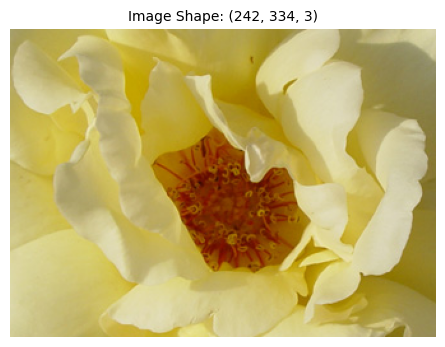

In [27]:
from PIL import Image
from pathlib import Path

# np.random.seed(42)

# Get posix path
image_path = '/hard-disk-2/users/mpershad/T91'
image_path = Path(image_path)

# 1. Get all the image path
image_path = list(image_path.glob("*.bmp"))

# 2. Pick a radom image path
idx = np.random.randint(0, len(image_path))
random_img_path = image_path[idx]

# 3. Open Image
# random_img = plt.imread(random_img_path)
random_img = Image.open(random_img_path).convert('RGB')
random_img = np.array(random_img)

# Plot using matplotlib
plt.figure(figsize=(6,4))
plt.imshow(random_img)
plt.title(f"Image Shape: {random_img.shape}", fontsize=10) # shape: [height, width, color_chnanel]
plt.axis("off")
plt.show()

## 2.2 Image Quality Metrics

1. Mean Squared Error(MSE) :  MSE loss function is evaluated only by the difference between the central pixels of Xi and the network output.

$$
L(\Theta) = \frac{1}{n} \sum_{i=1}^n \left \| F(Y_i; \Theta) - X_i \right \|^2,
$$

where n is the number of training examples. Using MSE as the loss functiion favors a high PSNR.

Alternative evaluation metrics,

1. Peak Signal To Noise Ratio(PSNR)

2. Structural Similarity Index(SSIM)

### 2.2.1 Mean Squared Error(MSE)

In [28]:
import numpy as np

def mse(original : np.ndarray, target : np.ndarray) -> float:

  """
  Compute the Mean Squared Error (MSE) between two images.

  Parameters:
  original (np.ndarray): The original image, expected to be a numpy array.
  compressed (np.ndarray): The compressed or modified image, expected to be a numpy array.

  Returns:
  float: The MSE value.
  """

  original_data = original.astype(np.float64)
  target_data = target.astype(np.float64)

  mse = np.mean((original_data - target_data)**2)
  return mse

### 2.2.2 Peak Signal To Noise Ratio(PSNR)

In [29]:
import numpy as np

def psnr(original : np.ndarray, target : np.ndarray) -> float:
  """
  Compute the Peak Signal to Noise Ratio (PSNR) between two images.

  Parameters:
  original (numpy.ndarray): The original image.
  compressed (numpy.ndarray): The compressed or modified image.

  Returns:
  float: The PSNR value in decibels (dB).
  """

  original_data = original.astype(np.float64)
  target_data = target.astype(np.float64)

  mse = np.mean((original_data - target_data)**2)
  if mse == 0:
    # MSE is zero means no noise is present in the signal.
    # Therefore, PSNR is infinite.
    return float('inf')

  max = 255.0
  psnr_val = 20*np.log10(max / np.sqrt(mse))
  return psnr_val

### 2.2.3 Structural Similarity Index(SSIM)

In [30]:
from skimage.metrics import structural_similarity as ssim_lib
from skimage.color import rgb2gray
import numpy as np

def ssim(original : np.ndarray, target : np.ndarray) -> float:
  """
  Compute the Structural Similarity Index (SSIM) between two images.

  Parameters:
  original (np.ndarray): The original image.
  compressed (np.ndarray): The compressed or modified image.

  Returns:
  float: The SSIM value.
  """

  # Convert images to grayscale if they are in color because SSIM is often computed in grayscale
  if original.ndim == 3:
    original = rgb2gray(original)
  if target.ndim == 3:
    target = rgb2gray(target)

  # Dynamically determine the data range for SSIM calculation
  # If the images are floating point, assume they are in [0, 1]
  if original.dtype == np.float32 or original.dtype == np.float64:
      data_range = 1
  else:
      # For integer types, use the maximum possible value of the dtype
      data_range = np.iinfo(original.dtype).max
  
  ssim_value, _ = ssim_lib(original, target, data_range=data_range, full=True)
  return ssim_value

### 2.2.4 Combined Metric

In [31]:
from typing import Tuple
import numpy as np

def combined_metric(original : np.ndarray, target : np.ndarray) -> Tuple:
  """
  Combined metric using MSE, PSNR and SSIM

  Parameters:
  original (np.ndarray): The original image.
  compressed (np.ndarray): The compressed or modified image.

  Return:
  Tuple: (MSE, PSNR, SSIM)
  """

  mse_val = mse(original, target)
  psnr_val = psnr(original, target)
  ssim_val = ssim(original, target)

  return (mse_val, psnr_val, ssim_val)

# 3.0 Transforming Data

To prepare our dataset for training a Super-Resolution CNN (SRCNN), we need to simulate low-resolution (LR) images from our high-resolution (HR) images. The following steps are taken for each image in our HR dataset:




## 3.1 LR Transformations

1. **Apply Gaussian Blur**:
   A Gaussian blur is applied to the HR images. This step is performed to smooth out the images and simulate the loss of detail that occurs in a real-world low-resolution image.

2. **Downscale**:
   The blurred HR images are then downsampled by a specified upscale factor.

3. **Upscale**:
   The downsampled images are then upscaled back to the original dimensions using bicubic interpolation.

4. **Save Processed Images**:
  The processed LR images are saved back to the filesystem for use in training the SRCNN.

In [32]:
import cv2 as cv
import numpy as np
from typing import Tuple

def generate_lr_image(image: np.ndarray, operation: str, scale: int, kernel_size: Tuple[int, int] = (5, 5), sigma: float = 0) -> np.ndarray:
  """
  Processes the image based on the specified operation: Gaussian Blur, Down-and-Up sampling, or both,
  for both grayscale and color images.

  Parameters:
  - image (np.ndarray): The input image to process. Can be grayscale or color.
  - operation (str): The operation to perform - 'blur', 'downup', 'both'.
  - scale (int): The downscaling factor for down-and-up sampling.
  - kernel_size (Tuple[int, int]): The kernel size for Gaussian blur.
  - sigma (float): The sigma value for Gaussian blur.

  Returns:
  - np.ndarray: Low-resolution image.
  """
  # Check if the image is grayscale or color
  if len(image.shape) == 2:
    # Grayscale image
    h, w = image.shape
  else:
    # Color image
    h, w, _ = image.shape

  lr_image = image

  if operation in ['blur', 'both']:
    # Apply Gaussian Blur
    lr_image = cv.GaussianBlur(lr_image, kernel_size, sigma)

  if operation in ['downup', 'both']:
    # Downscale and then upscale
    if len(image.shape) == 2:
      # Grayscale
      lr_image = cv.resize(cv.resize(lr_image, (w // scale, h // scale), interpolation=cv.INTER_CUBIC), (w, h), interpolation=cv.INTER_CUBIC)
    else:
      # Color
      lr_image = cv.resize(cv.resize(lr_image, (w // scale, h // scale), interpolation=cv.INTER_CUBIC), (w, h), interpolation=cv.INTER_CUBIC)

  return lr_image

In [33]:
from PIL import Image

def plot_hr_lr_images(hr_img_dir: str, n: int = 3, seed=52):

  """
  Plot random HR and LR image pairs side by side
  """
  if seed:
    np.random.seed(seed)

  plt.figure(figsize=(10, 10))

  random_idx_list = list(np.random.randint(0, len(os.listdir(hr_img_dir)), n))

  for i, idx in enumerate(random_idx_list):
    hr_img_path = os.path.join(hr_img_dir, os.listdir(hr_img_dir)[idx])

    hr_img = Image.open(hr_img_path).convert('RGB')

    hr_img = np.array(hr_img)
    lr_img = generate_lr_image(hr_img, operation, scale, kernel_size, sigma)

    # Calculate the combined metrics
    metrics = combined_metric(hr_img, lr_img)
    metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(hr_img)
    plt.title(f"HR Image\nSize: {hr_img.shape}", fontsize=8)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(lr_img)
    plt.title(f"LR Image\nSize: {lr_img.shape}", fontsize=8)
    plt.xlabel(metrics_str, fontsize=8)  # Display combined metrics here
    plt.xticks([])
    plt.yticks([])
    # plt.axis("off")

  plt.tight_layout()
  plt.show()

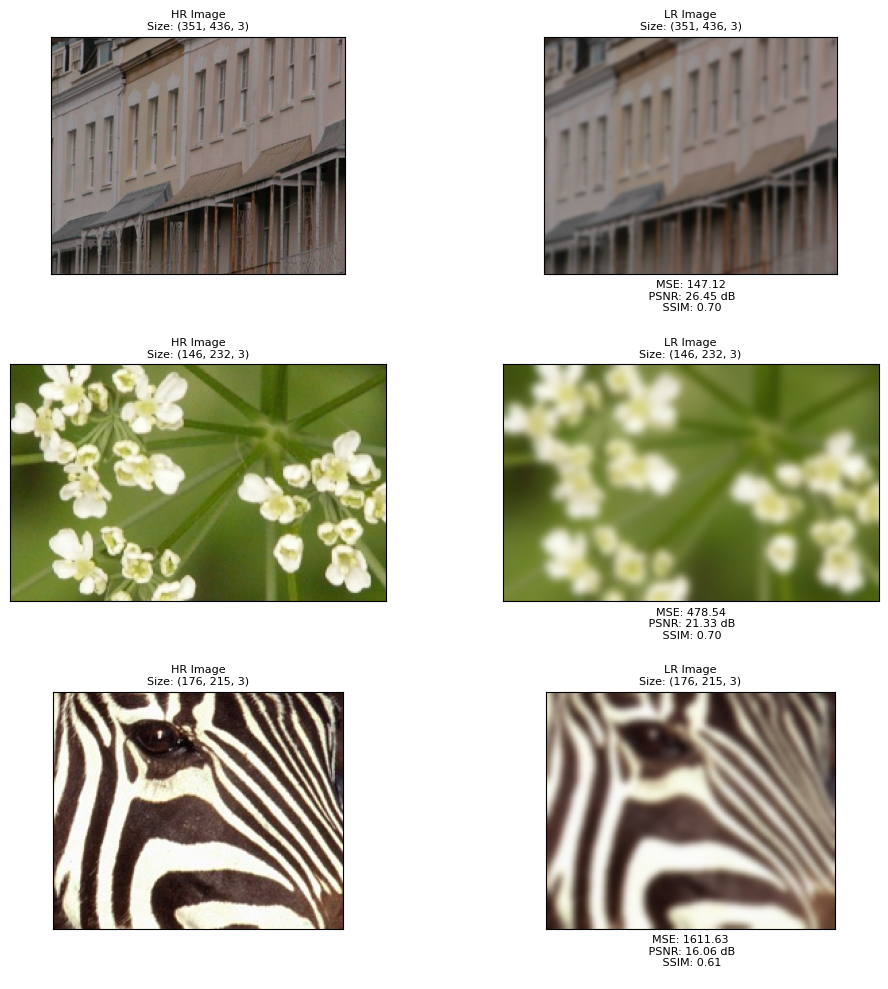

In [34]:
plot_hr_lr_images(hr_img_dir = "/hard-disk-2/users/mpershad/T91", n = 3)

## 3.2 Modcrop

In [35]:
def modcrop(img, modulo):

  """
  Crop the image to a size that is divisible by the modulo value.

  Parameters:
  - img (np.ndarray): The input image to crop.
  - modulo (int): The value to crop the image size to.

  Returns:
  - np.ndarray: The cropped image.
  """

  if img.ndim == 2:
    sz = img.shape
    sz = sz - np.mod(sz, modulo)
    img_cropped = img[0:sz[0], 0:sz[1]]
  elif img.ndim == 3:
    sz = img.shape[0:2]
    sz = sz - np.mod(sz, modulo)
    img_cropped = img[0:sz[0], 0:sz[1], :]
  else:
    raise ValueError("Unsupported image dimensions")

  return img_cropped

## 3.3 Sub Images using different blurring options

In [36]:
import os
import sys
import cv2 as cv
import numpy as np
import argparse
from PIL import Image
from typing import Tuple

def generate_patches(filepath: str, patches_label_dir: str, patches_data_dir: str, operation: str, kernel_size: Tuple[int, int] = (5, 5), sigma: float = 0, size_input:int = 33, scale:int = 3, stride:int = 14, padding: str = 'valid', color_channel: int = 1):
  """
  Generates training patches from a single image file and saves them to specified directories.

  This function takes an image file, processes it to generate low-resolution (LR) and high-resolution (HR) patches, and saves these patches as individual image files in specified directories. LR patches are generated by downsampling and then upsizing the original HR image using bicubic interpolation. The function then extracts patches of specified sizes from both the LR and HR images using a specified stride.

  Parameters:
  - filename (str): Path to the original HR image file.
  - patches_label_dir (str): Directory path where HR (label) patches will be saved.
  - patches_data_dir (str): Directory path where LR (input/data) patches will be saved.
  - size_input (int, optional): Size of the LR patches. Default is 33.
  - scale (int, optional): Factor by which the HR image is downsampled to generate the LR image. Default is 3.
  - stride (int, optional): Stride with which patches are extracted from the images, controlling the overlap. Default is 14.
  - padding (str, optional): Padding type for the model ('same' or 'valid'). Default: 'valid'.
  - color_channel (int, optional): Number of color channels in the image. Default: 1.

  Returns:
  - int: The total number of patches generated from the image.

  Raises:
  - TypeError: If the input image is not a PIL Image object.
  """
  # Create directories for patches if they don't exist
  os.makedirs(patches_label_dir, exist_ok=True)
  os.makedirs(patches_data_dir, exist_ok=True)

  filename = os.path.basename(filepath).split('.')[0]

  # Calculate size_label based on padding
  if padding == 'same':
    size_label = size_input
  else:
    size_label = size_input - sum([f - 1 for f in arch])

  pad = (size_input - size_label) // 2

  img = Image.open(filepath).convert('RGB')

  if not isinstance(img, Image.Image):
    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

  # Handle color images
  if color_channel == 3:
    img = np.array(img)  # Convert to NumPy array
  else:
    img_ycbcr = img.convert('YCbCr')
    img = np.array(img_ycbcr)[:, :, 0]  # Extract Y channel

  im_label = modcrop(img, scale)
  h, w = im_label.shape[:2]
  total_patches = 0

  # Process the image for low-resolution version
  im_input = generate_lr_image(im_label, operation, scale, kernel_size, sigma)

  # Save each patch to the respective directories
  for x in range(0, h-size_input+1, stride):
    for y in range(0,  w-size_input+1, stride):
      # Extract the data and label patch
      data_patch = im_input[x:x+size_input, y:y+size_input]
      label_patch = im_label[x+pad:x+pad+size_label, y+pad:y+pad+size_label]

      # Convert patches back to images
      data_patch_img = Image.fromarray(data_patch)
      label_patch_img = Image.fromarray(label_patch)

      total_patches += 1

      # Save the patch
      data_patch_img.save(os.path.join(patches_data_dir, f'{filename}_{x}_{y}.png'))
      label_patch_img.save(os.path.join(patches_label_dir, f'{filename}_{x}_{y}.png'))

  return total_patches

## 3.4 Unpaired Split

In [47]:
# Generating training data
train_data_dir = "/hard-disk-2/users/mpershad/T91"
size_input = 33
stride = 14

# HR Images for training
paired_hr_filenames = sorted(os.listdir(train_data_dir)) 

In [ ]:
from tqdm.auto import tqdm
total = 0
for filename in tqdm(paired_hr_filenames):
  filepath = os.path.join(train_data_dir, filename)
  if os.path.isfile(filepath):
    patches_count = generate_patches(filepath=filepath,
            patches_label_dir='../Data/Unpaired/Train/pHR',
            patches_data_dir='../Data/Unpaired/Train/pLR',
            operation=operation,
            kernel_size=kernel_size,
            sigma=sigma,
            size_input=size_input,
            scale=scale,
            stride=stride,
            padding=padding,
            color_channel=color_channel)
    total += patches_count
    print(f'Generated {patches_count} patches from {filename}')

print(f'Total patches generated: {total}')

In [ ]:
# Generating Validation data
validation_data_dir = "/hard-disk-2/users/mpershad/DIV2K_valid_HR"
size_input = 33
stride = 21

total = 0
for filename in tqdm(os.listdir(validation_data_dir)[:3]):
  filepath = os.path.join(validation_data_dir, filename)
  if os.path.isfile(filepath):
    patches_count = generate_patches(filepath=filepath,
            patches_label_dir='../Data/Unpaired/Validation/pHR',
            patches_data_dir='../Data/Unpaired/Validation/pLR',
            operation=operation,
            kernel_size=kernel_size,
            sigma=sigma,
            size_input=size_input,
            scale=scale,
            stride=stride,
            padding=padding,
            color_channel=color_channel)
    total += patches_count
    print(f'Generated {patches_count} patches from {filename}')

print(f'Total patches generated: {total}')

# 4.0 Loading Images data with custom 'Dataset'

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directories(the directory we'd like to get data from) as well as a transfrom if we'd like to transform out data
3. Create several attribute:
  * lr and hr path of our images
  * tranform - The transfrom we'd like to use
4. Create a function to `load_image()`, this function will open the image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

## 4.1 Custom Dataset for Loading paired Images(LR and HR) 

In [50]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List

class SRCNNDataset(Dataset):

  # 2. Initialize with a lr/hr_img_dir and transform(optional) parameter
  def __init__(self, lr_img_dir : str, hr_img_dir : str, ext : str,transform = None):

    # 3. Create class attributes
    self.img_paths = sorted(list(Path(lr_img_dir).glob(f"*.{ext}")))
    self.label_paths = sorted(list(Path(hr_img_dir).glob(f"*.{ext}")))

    # Setup transform
    self.transform = transform


  # Make function to load images
  def load_target(self, idx : int) -> Image.Image:

    """Opens an image via file path and returns it"""
    target_path = self.img_paths[idx]
    return Image.open(target_path)

  def load_label(self, idx : int) -> Image.Image:

    """Opens an image via file path and returns it"""
    label_path = self.label_paths[idx]
    return Image.open(label_path)

  # Overwrite the __len()__ method
  def __len__(self)-> int:

    "Returns the total number of samples."
    return len(self.img_paths)

  def __getitem__(self, idx : int) -> Tuple[torch.tensor, torch.tensor]:

    """Returns one sample of data, data and label (X, y)"""
    img = self.load_target(idx)
    target = self.load_label(idx)

    # Transform if necessary
    if self.transform:
      img = self.transform(img)
      target = self.transform(target)

    return img, target # return data, label (X, y)

### 4.1.1 Transforms

In [51]:
from torchvision import transforms
# Augment train data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

validation_transform = transforms.Compose([
    transforms.ToTensor()
])

### 4.1.2 Train and Validation Paired Dataset

In [52]:
train_imgs = '../Data/Unpaired/Train/pLR'
train_labels = '../Data/Unpaired/Train/pHR'

val_imgs = '../Data/Unpaired/Validation/pLR'
val_labels = '../Data/Unpaired/Validation/pHR'

train_data_custom = SRCNNDataset(lr_img_dir = train_imgs,
                          hr_img_dir = train_labels,
                          ext = "png",
                          transform = train_transform)

validation_data_custom = SRCNNDataset(lr_img_dir = val_imgs,
                          hr_img_dir = val_labels,
                          ext = "png",
                          transform = validation_transform)

train_data_custom, validation_data_custom

(<__main__.SRCNNDataset at 0x7f98c472d7f0>,
 <__main__.SRCNNDataset at 0x7f98c472d4c0>)

In [53]:
print(f"Length of Training Data: {len(train_data_custom)}")
print(f"Length of Training Data: {len(validation_data_custom)}")

Length of Training Data: 21884
Length of Training Data: 18432


### 4.1.3 Turn custom Dataset into DataLoader

In [54]:
import os
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 64

# Create dataloaders for each set
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     num_workers=os.cpu_count(),
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

validation_dataloader_custom = DataLoader(dataset=validation_data_custom,
                                          num_workers=os.cpu_count(),
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

train_dataloader_custom, validation_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f9867d06eb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9867d06e20>)

In [55]:
len(train_dataloader_custom), len(validation_dataloader_custom)

(342, 288)

In [56]:
# Get first batch of image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out shape
print(f"Image Batch shape: {img_custom.shape} ->[batch_size, color_channel, height, width]")
print(f"Label Shape: {label_custom.shape}")

Image Batch shape: torch.Size([64, 3, 33, 33]) ->[batch_size, color_channel, height, width]
Label Shape: torch.Size([64, 3, 33, 33])


## 4.3 Create a function to display random images

1. Take `Dataset` and `n` number of images to display
2. To prevent display getting out of hand, we'll cap `n` to 10 iamges
3. Set the random seed
4. Get a list of random indexes for plotting
5. Setup `matplotlib` plot
6. Loop through random list of index found in Step : 4  and plot them with `matplotlib`
7. Make sure the images are of right shape before we plot them.

In [57]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          n: int = 5,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. Adjust display if n is high
  if n > 5:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")


  if seed:
    torch.manual_seed(seed)

  # 3. Get random sample of indexes
  random_samples_idx = torch.randint(0, len(dataset), size=([1, n])).tolist()[0]

  # 4. Setup plot
  plt.figure(figsize=(6,18))

  # 5. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_img, targ_label = dataset[targ_sample]

    # 6. Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channel]
    targ_img = targ_img.permute(1, 2, 0)
    targ_label = targ_label.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(n, 2, 2*i+1)
    plt.imshow(targ_img, cmap="gray")
    if display_shape:
      plt.title(f"LR Image\nSize: {targ_img.shape}", fontsize = 8)
      mse_val = mse(targ_img.numpy(), targ_label.numpy())
      psnr_val = psnr(targ_img.numpy(), targ_label.numpy())
      metrics_str = f"MSE: {mse_val:.2f}\n PSNR: {psnr_val:.2f} dB\n"
      plt.xlabel(metrics_str, fontsize=8)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(n, 2, 2*i+2)
    plt.imshow(targ_label, cmap="gray")
    if display_shape:
      plt.title(f"HR Image\nSize: {targ_label.shape}", fontsize = 8)
    plt.xticks([])
    plt.yticks([])

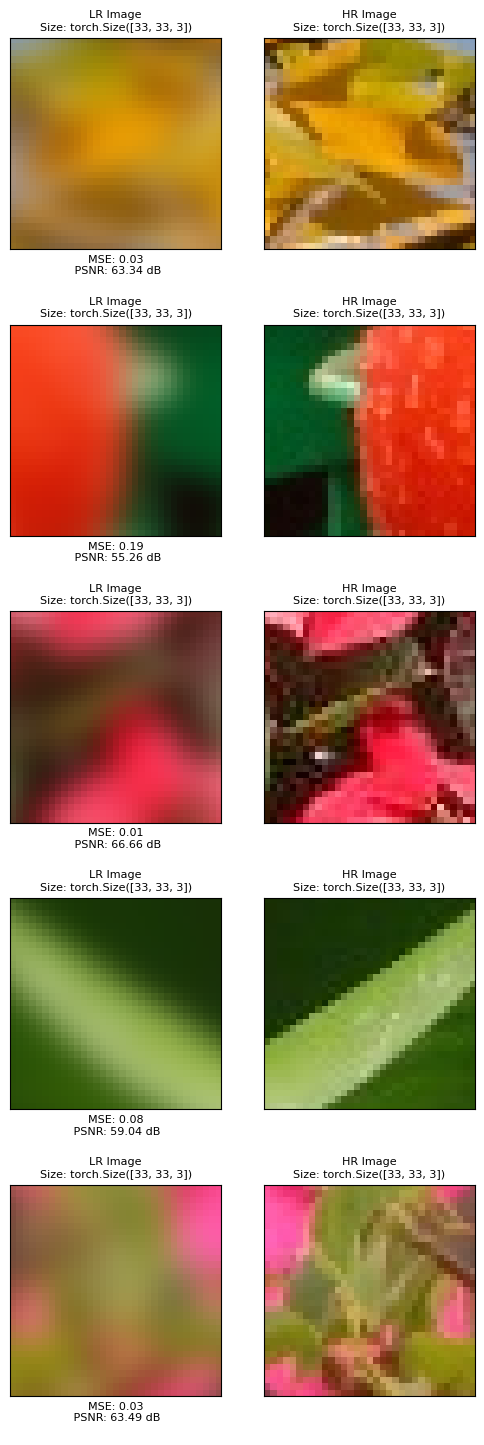

In [58]:
# Display random images from custom created Dataset
display_random_images(dataset=train_data_custom,
                      n=5,
                      seed=None)

# 5.0 Tracking experiments

## 5.1 Config

In [59]:
config={
    'start_epoch': 0,
    'end_epoch': 1000,
    'learning_rate_first_two_layers': 2e-4,
    'learning_rate_last_layer': 2e-5,
    'architecture': 'SRCNN',
    'kernel_sizes': arch,
    'hidden_units_1': 128,
    'hidden_units_2': 64,
    'input_channels': color_channel,
    'output_channels': color_channel,
    'padding': padding,
    'checkpoint_interval': 250  # Added to config for flexibility
}

In [60]:
import wandb

# Try to Log in to your W&B account
try:
    wandb.login()
    print("Successfully logged in to W&B!")

    # Initialize a W&B run
    wandb.init(project='SRCNN+VGG', entity='pershadmayank', config=config)

except Exception as e:
    print("Error during login:", e)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: pershadmayank. Use `wandb login --relogin` to force relogin


Successfully logged in to W&B!


## 5.2 Setup Loss function and optimizer

In [61]:
import torch.nn as nn
import torch

# Recreate an instance of SRCNN Model using the wandb config
model = SRCNN(input_channels=config['input_channels'],
                     hidden_units_1=config['hidden_units_1'],
                     hidden_units_2=config['hidden_units_2'],
                     kernel_sizes=config['kernel_sizes'],
                     padding=padding,
                     output_channels=config['output_channels']).to(device)

# Separate parameters for different learning rates
first_two_layers_params = list(model.conv_block_1.parameters())
last_layer_params = list(model.conv_block_2.parameters())

# Setup the optimizer with learning rates from wandb.config
optimizer = torch.optim.Adam([
    {'params': first_two_layers_params, 'lr': config['learning_rate_first_two_layers']},
    {'params': last_layer_params, 'lr': config['learning_rate_last_layer']}
])

# Setup the loss function
loss_fn = nn.MSELoss()

In [62]:
model_name = str(input("Enter model name:"))

In [ ]:
# Train the model using the wandb.config values
model_results = train(model=model,
                      train_dataloader=train_dataloader_custom,
                      test_dataloader=validation_dataloader_custom,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      path=model_name,
                      start_epoch=config['start_epoch'],
                      end_epoch=config['end_epoch'],
                      device=device,
                      checkpoint_interval=config['checkpoint_interval'])

In [ ]:
# q: How to add more parametes to the above wandb.init() config after the model is trained?
# Ans: You can add more parameters to the wandb.init() config after the model is trained by calling wandb.config.update() method. 
# This method allows you to update the configuration dictionary with new key-value pairs. Here's an example: wandb.config.update({'new_param': 'new_value'}) This will add a new parameter 'new_param' with the value 'new_value' to the configuration dictionary. 
# You can call this method multiple times to add more parameters as needed.

# Get the last epoch number(Due to early stooping)
last_epoch = len(model_results['train_loss'])
wandb.config.update({'last_epoch': last_epoch})


## 5.3 Save Results Dictionary

In [65]:
import pickle
import os

metrics_path = f'../Metrics/SRCNN'

if not os.path.exists(metrics_path):
  os.makedirs(metrics_path)

pickle_file_path = os.path.join(metrics_path, f"metrics_{model_name}.pkl")


with open(pickle_file_path, 'wb') as file:
    pickle.dump(model_results, file)

print(f"Results saved to {pickle_file_path}")

Results saved to ../Metrics/SRCNN/metrics_model1_9_3_5.pkl


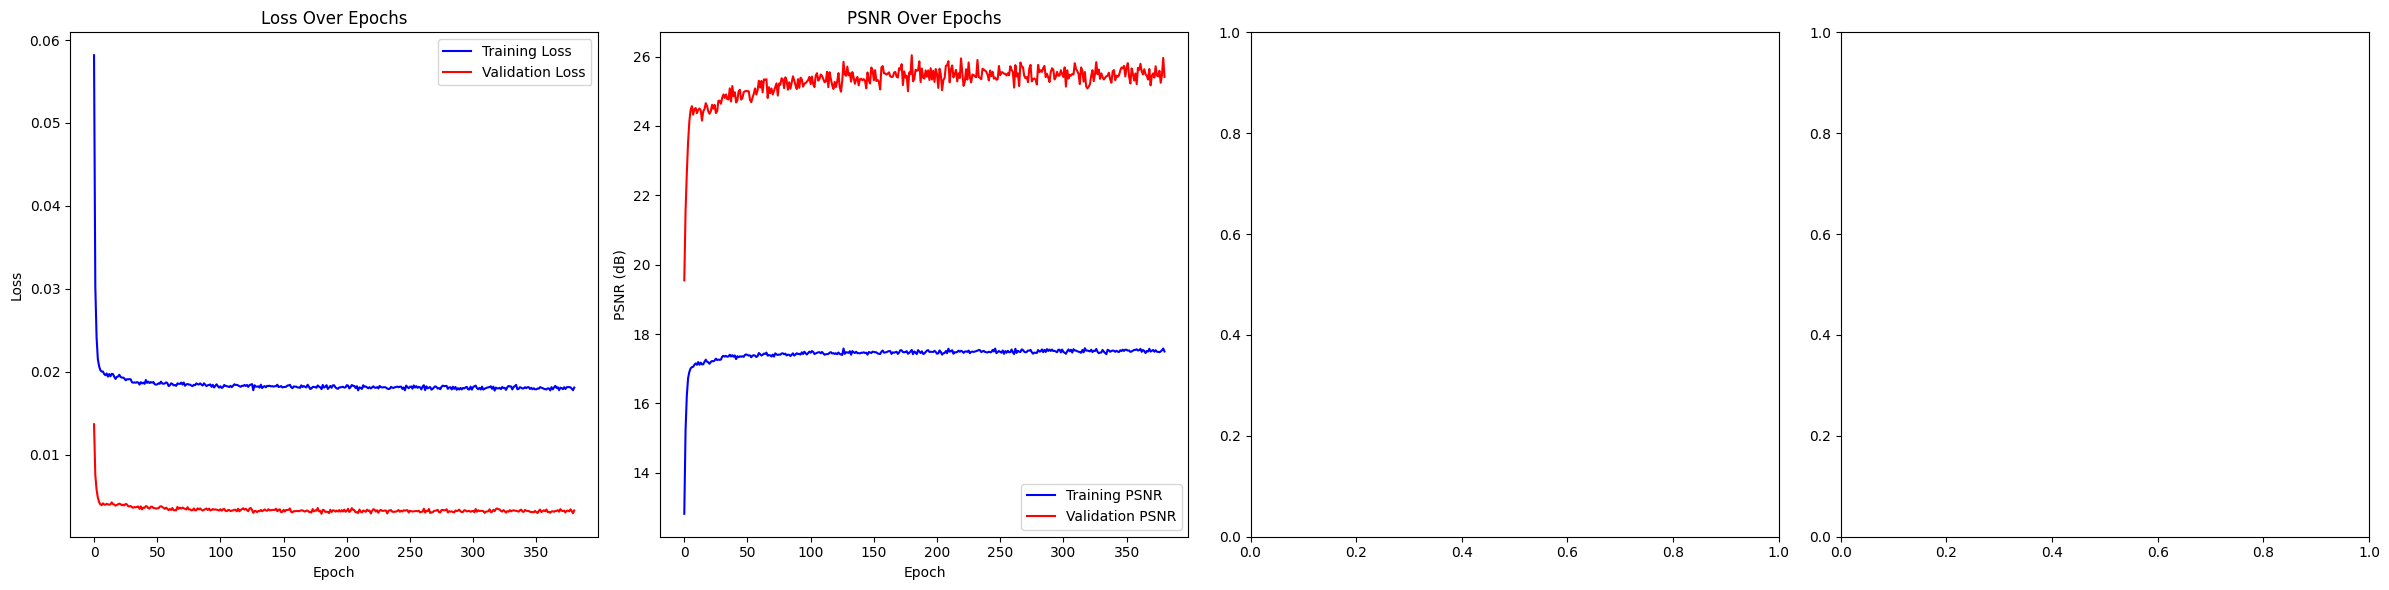

In [66]:
plot_loss_curves(model_results)

# 7.0 Inference using trained Model


In [128]:
# Replace with the run ID you want to download from
run_id = input("Enter runtime ID: ")

In [129]:
# Replace with the artifact name
artifact = input("Enter artifact name: ")

In [151]:
model = SRCNN.load_model_from_wandb(run_id=run_id,
                                    artifact_id=artifact,
                                    device=device).to(device)

model

wandb:   1 of 1 files downloaded.  


SRCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
)

In [137]:
# Hyperparameters for Gaussian Blur
kernel_size = (15, 15)
sigma = 2.5
scale = 3

In [138]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# /content/SRCNN/Data/Test/LR/baboon.bmp
# test_img_path = input("Enter Image Path: ")
test_img_path = "../Data/Unpaired/Test/HR/baboon.bmp"

# Convert BMP to JPEG or PNG
hr_img = Image.open(test_img_path).convert('RGB')
hr_img = np.array(hr_img)

# Generate Low Resolution Image
test_img = generate_lr_image(hr_img, operation, scale, kernel_size, sigma)

# Convert the RGB image to a PyTorch tensor
test_img_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Convert RGB to Image Tensor
test_img_tensor = test_img_transform(test_img)

# Move the tensor to the designated device
test_img_tensor = test_img_tensor.to(device)

# Print out image data
print(f"Test Image Tesnor:\n {test_img_tensor}\n")
print(f"Test Image Shape: {test_img_tensor.shape}")
print(f"Test Image stype: {test_img_tensor.dtype}")

Test Image Tesnor:
 tensor([[[0.2824, 0.2784, 0.2706,  ..., 0.2941, 0.2784, 0.2706],
         [0.2824, 0.2784, 0.2706,  ..., 0.2941, 0.2784, 0.2745],
         [0.2824, 0.2784, 0.2745,  ..., 0.3020, 0.2902, 0.2863],
         ...,
         [0.2824, 0.2824, 0.2824,  ..., 0.1843, 0.1804, 0.1804],
         [0.2706, 0.2706, 0.2706,  ..., 0.1765, 0.1765, 0.1725],
         [0.2667, 0.2667, 0.2706,  ..., 0.1765, 0.1725, 0.1725]],

        [[0.2627, 0.2588, 0.2549,  ..., 0.3216, 0.3098, 0.3020],
         [0.2627, 0.2588, 0.2549,  ..., 0.3216, 0.3098, 0.3059],
         [0.2667, 0.2627, 0.2588,  ..., 0.3294, 0.3176, 0.3137],
         ...,
         [0.3608, 0.3608, 0.3608,  ..., 0.1608, 0.1608, 0.1608],
         [0.3451, 0.3451, 0.3490,  ..., 0.1529, 0.1529, 0.1529],
         [0.3412, 0.3412, 0.3451,  ..., 0.1529, 0.1490, 0.1490]],

        [[0.0824, 0.0824, 0.0784,  ..., 0.1569, 0.1529, 0.1529],
         [0.0824, 0.0824, 0.0824,  ..., 0.1569, 0.1529, 0.1529],
         [0.0824, 0.0824, 0.0824,  ...

In [139]:
test_img_tensor.shape, test_img_tensor.unsqueeze(dim=0).shape

(torch.Size([3, 480, 500]), torch.Size([1, 3, 480, 500]))

In [140]:
# Set it to evaluation mode
model.eval()
with torch.inference_mode():
  img_predicted = model(test_img_tensor.unsqueeze(dim=0).to(device))

In [141]:
img_predicted = img_predicted.cpu().squeeze()

# Rearrange the channels
img_predicted = img_predicted.permute(1, 2, 0)

# Convert to numpy array
img_predicted = img_predicted.numpy() * 255
img_predicted = img_predicted.astype(np.uint8)

img_predicted.shape

(480, 500, 3)

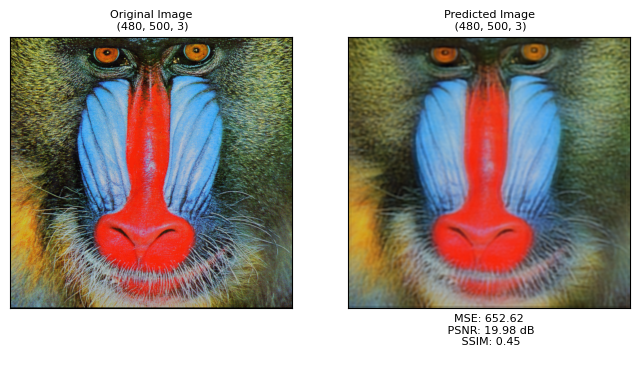

In [142]:
import matplotlib.pyplot as plt

# Calculate the combined metrics
metrics = combined_metric(hr_img, img_predicted)
metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(hr_img)
plt.title(f"Original Image\n {hr_img.shape}", fontsize=8)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_predicted)
plt.title(f"Predicted Image\n {img_predicted.shape}", fontsize=8)
plt.xlabel(metrics_str, fontsize=8)  # Display combined metrics here
plt.xticks([])
plt.yticks([])
plt.show()

## 7.1 Function to do prediction and Plotting

**Note:** To make a prediction using the trained SRCNN model on a custom image:

1. Load the image using PIL and ensure it's in RGB format.
2. Apply necessary transformations to the RGB image (e.g., resize, convert to tensor).
3. Add a batch dimension to the tensor to make it suitable for the model.
4. Set the model to evaluation mode using `model.eval()`.
5. Move the tensor to the same device as the model (if using GPU).
6. Pass the tensor through the model to get the predicted RGB image.
Ensure that all tensors are of the correct datatype (typically `torch.float32`) and that the preprocessing steps match those used during the model's training phase.


In [143]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2 as cv

def pred_and_plot_image(model: torch.nn.Module, image_path: str, lr_image, lr_image_args, transform=None, plot=False, device: torch.device = torch.device('cpu')):
 
  # Load image and convert to RGB
  img = Image.open(image_path).convert('RGB')
  img = np.array(img)

  # Generate Low Resolution Image
  lr_img = lr_image(img, **lr_image_args) 

  # Convert the RGB image to a PyTorch tensor
  if transform:
    img_tensor = transform(lr_img)
  else:
    # Create a transform
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img_tensor = transform(lr_img)
  
  # Move the tensor to the designated device
  img_tensor = img_tensor.to(device)

  # Set model to evaluation mode
  model.eval()
  with torch.inference_mode():
    img_predicted = model(img_tensor.unsqueeze(dim=0).to(device))

  # Move the predicted image to the CPU
  img_predicted = img_predicted.cpu().squeeze()

  # Rearrange the channels
  img_predicted = img_predicted.permute(1, 2, 0)

  # Convert to numpy array
  img_predicted = img_predicted.numpy() * 255
  
  # Convert to uint8
  img_predicted = img_predicted.astype(np.uint8)

  if plot:
    # Calculate the combined metrics b/w original and predicted image
    metrics = combined_metric(img, img_predicted)
    metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

    # Calculate the combined metrics b/w original and LR image
    metrics_lr = combined_metric(img, lr_img)
    metrics_str_lr = f"MSE: {metrics_lr[0]:.2f}\n PSNR: {metrics_lr[1]:.2f} dB\n SSIM: {metrics_lr[2]:.2f}\n"

    plt.figure(figsize=(12, 10))

    # Plot the LR Image
    plt.subplot(1, 3, 1)
    plt.imshow(lr_img)
    plt.title("LR Image")
    plt.xlabel(metrics_str_lr)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.title("Original HR Image")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 3)
    plt.imshow(img_predicted)
    plt.title("Predicted Image")
    plt.xlabel(metrics_str)
    plt.xticks([])
    plt.yticks([])
    plt.show()
  return lr_img, img, img_predicted

In [144]:
# /content/SRCNN/Data/Test/LR/lenna.bmp
# test_img_path = input("Enter Image Path: ")
test_img_path = "../Data/Unpaired/Test/HR/lenna.bmp"

In [145]:
# Parameters for generate_lr_image
lr_image_args = {
    'operation': operation,
    'scale': scale,
    'kernel_size': kernel_size,
    'sigma': sigma
}

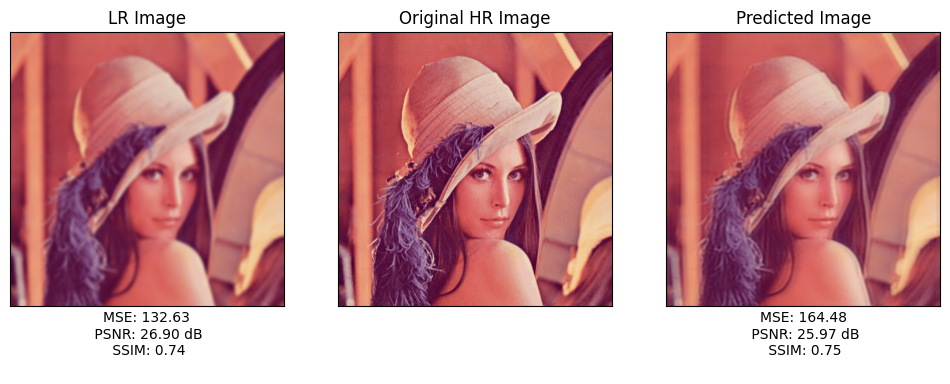

In [146]:
lr_img, img, pred_img = pred_and_plot_image(model=model,  # Replace with your model variable
                                image_path=test_img_path,  # Replace with the path to your image
                                lr_image=generate_lr_image,  # The function to generate LR image
                                lr_image_args=lr_image_args,  # Arguments for the LR image function
                                transform=test_img_transform,  # The transformation to apply
                                device=device,  # The device (cpu or cuda)
                                plot=True)

## 7.2 Feature extraction using VGG19 

In [147]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Create dictionary to store the metrics
metrics_dict = {'Filename': [], 'MSE': [], 'PSNR': [], 'SSIM': []}

# Tansform for preforming same preprocessing as VGG19 before extracting features
vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initalize VGG19 feature extractor
vgg19 = VGG19FeatureExtractor().to(device)

# Store LR, HR and SR features with filename as key
features = {}

# Apply the above transform to all the images in test set
test_img_dir = "../Data/Unpaired/Test/HR"
for f in tqdm(os.listdir(test_img_dir)):
    
    img_path = os.path.join(test_img_dir, f)

    # Get the filename
    filename = f.split('.')[0]

    lr_img, img, pred_img = pred_and_plot_image(model=model,  # Replace with your model variable
                                    image_path=img_path,  # Replace with the path to your image
                                    lr_image=generate_lr_image,  # The function to generate LR image
                                    lr_image_args=lr_image_args,  # Arguments for the LR image function
                                    device=device,  # The device (cpu or cuda)
                                    plot=False)
    # Get the metrics
    metrics = combined_metric(img, pred_img)

    # Update the dictionary
    metrics_dict['Filename'].append(filename)
    metrics_dict['MSE'].append(metrics[0])
    metrics_dict['PSNR'].append(metrics[1])
    metrics_dict['SSIM'].append(metrics[2])

    # Convert PIL images to tensors and preprocess for VGG19
    lr_img_tensor = vgg_transform(Image.fromarray(lr_img)).unsqueeze(0)
    img_tensor = vgg_transform(Image.fromarray(img)).unsqueeze(0)
    pred_img_tensor = vgg_transform(Image.fromarray(pred_img)).unsqueeze(0)

    # Extract features of shape [C, H, W] 
    lr_features = vgg19(lr_img_tensor.to(device)).detach().cpu().numpy()
    img_features = vgg19(img_tensor.to(device)).detach().cpu().numpy()
    pred_img_features = vgg19(pred_img_tensor.to(device)).detach().cpu().numpy()

    # Update the features dictionary
    features[filename] = {'LR': lr_features, 'HR': img_features, 'Predicted': pred_img_features}

# Flatten the corresponding LR, HR and SR features and stack 
lr_features_flatten = np.stack([features[filename]['LR'].flatten() for filename in features])
hr_features_flatten = np.stack([features[filename]['HR'].flatten() for filename in features])
pred_img_features_flatten = np.stack([features[filename]['Predicted'].flatten() for filename in features])

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(metrics_dict)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 19/19 [00:01<00:00,  9.51it/s]


In [148]:
filename = "lenna"

# Print the size of unflattened features
print(f"Size of features: {features[filename]['LR'].shape}")

# Print the size of features
print(f"Size of features: {lr_features_flatten[0].shape[0]}")

Size of features: (1, 512, 14, 14)
Size of features: 100352


## 7.3 TSNE Plot of VGG Features for LR, HR and SR

In [ ]:
%%capture
from sklearn.manifold import TSNE

# stack all the features for TSNE
all_features = np.vstack([lr_features_flatten, hr_features_flatten, pred_img_features_flatten])

# q: Do we need to flatten the features after stacking them?
# a: No, we don't need to flatten the features after stacking them. The features are already flattened.

# Apply TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(all_features)

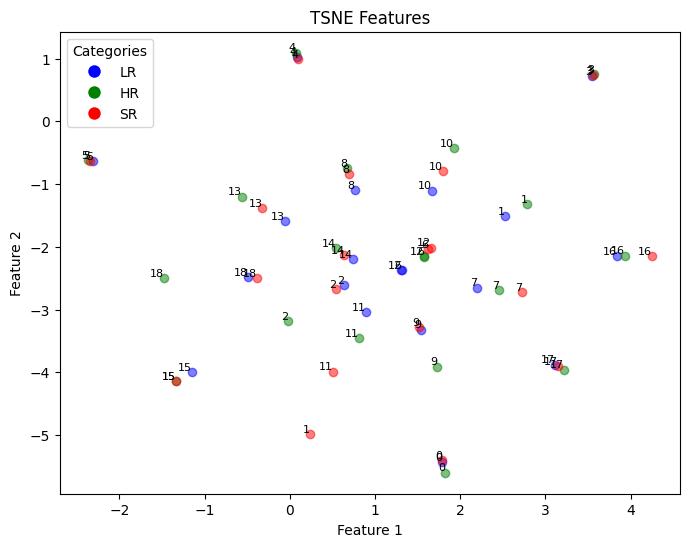

In [150]:
plt.figure(figsize=(8, 6))

# Colors and labels for each category
colors = ['blue', 'green', 'red']
category_labels = ['LR', 'HR', 'SR']
n = len(lr_features_flatten)  # Number of images per category

# Plot points and label them with numbers
for i in range(3*n):
    category = i // n  # Determine the category of the current point
    plt.scatter(tsne_features[i, 0], tsne_features[i, 1], color=colors[category], alpha=0.5)
    # Add a numerical label near each point
    plt.text(tsne_features[i, 0], tsne_features[i, 1], str(i % n), fontsize=8, ha='right', va='bottom')

# Create custom legend handles
from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=l)
                  for c, l in zip(colors, category_labels)]

plt.title('TSNE Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# Add the custom legend to the plot
plt.legend(handles=legend_handles, title="Categories")
plt.show()


## 7.4 Heatmaps of Feature Extraction

In [124]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_map(feature):
    """
    Plots heatmaps of LR, HR and SR feature maps.
    feature_maps: Dictinoary containing filename and Dictinoary of feature maps
    """

    # Get the filename
    filename = feature[0] 
    feature_maps = feature[1]

    # Unpack the feature maps
    lr_features = feature_maps['LR'].squeeze()
    hr_features = feature_maps['HR'].squeeze()
    pred_img_features = feature_maps['Predicted'].squeeze()

    # If there are multiple feature channels, take the mean to get a single heatmap
    if lr_features.shape[0] > 1:
        lr_features = np.mean(lr_features, axis=0)
    
    if hr_features.shape[0] > 1:
        hr_features = np.mean(hr_features, axis=0)
    
    if pred_img_features.shape[0] > 1:
        pred_img_features = np.mean(pred_img_features, axis=0)
    
    # Plot the heatmaps using (1,3) grid with filename
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Feature Maps for {filename}', fontsize=16)
    # Add colorbar to each heatmap
    plt.subplot(1, 3, 1)
    plt.imshow(lr_features, cmap='viridis')
    plt.colorbar()
    plt.title('LR Feature Map')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(hr_features, cmap='viridis')
    plt.title('HR Feature Map')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_img_features, cmap='viridis')
    plt.title('SR Feature Map')
    plt.colorbar()
    plt.axis('off') 

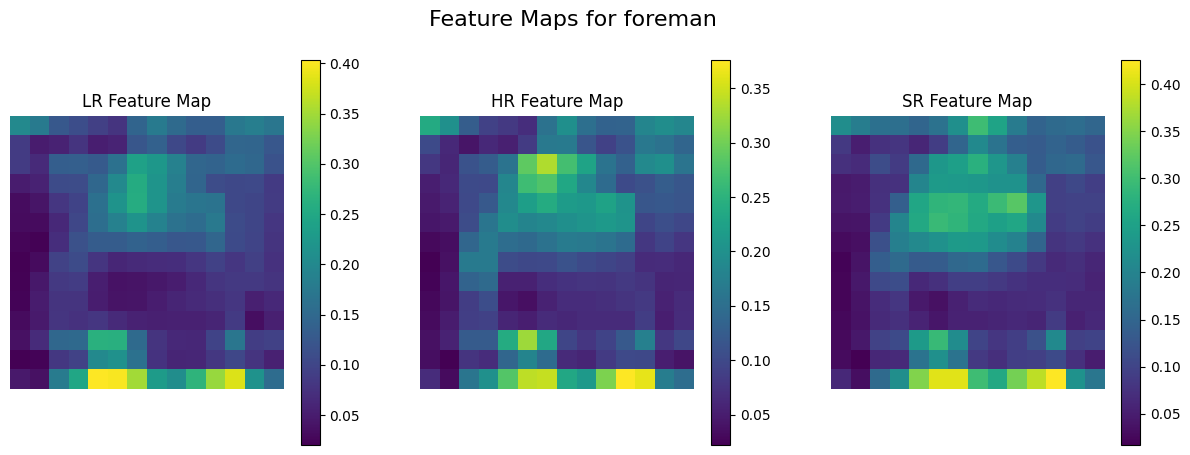

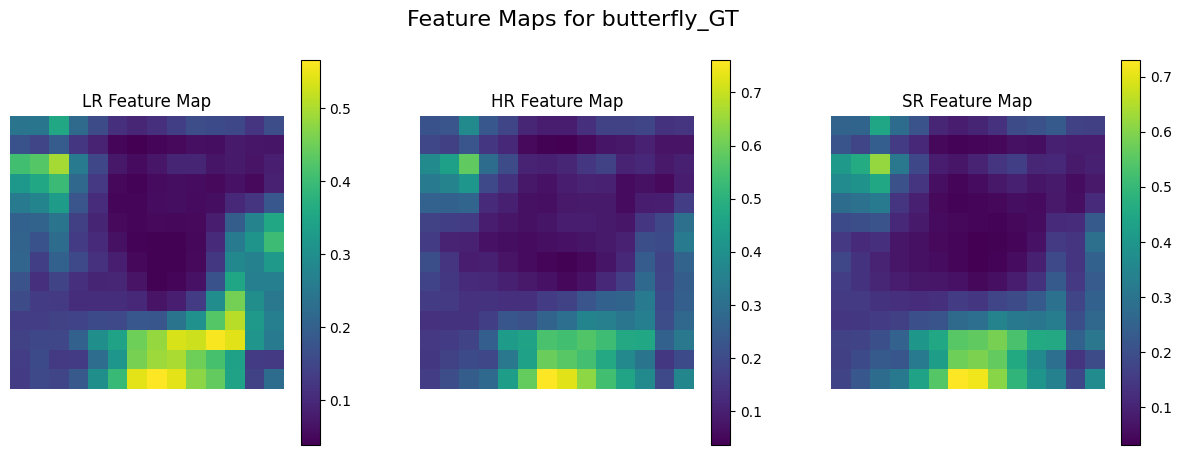

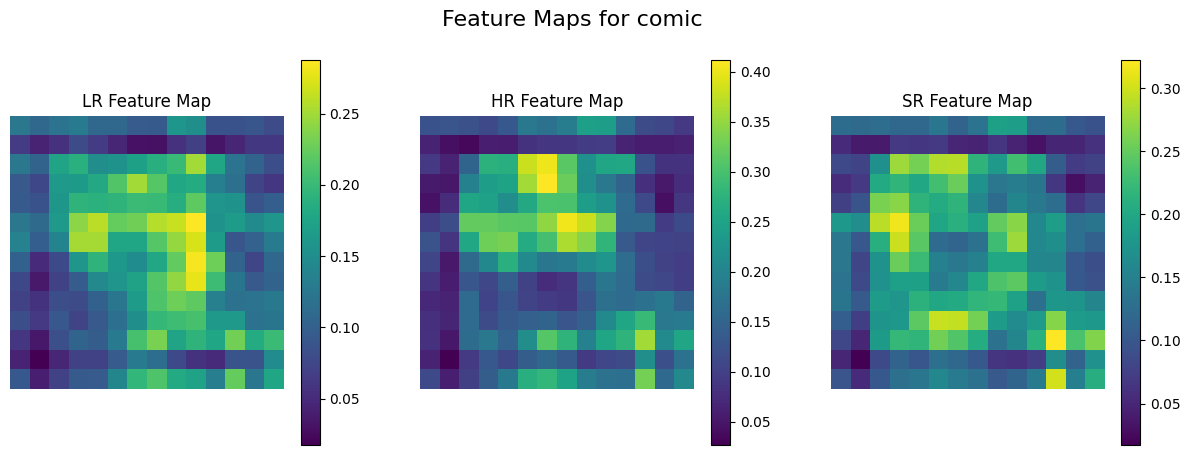

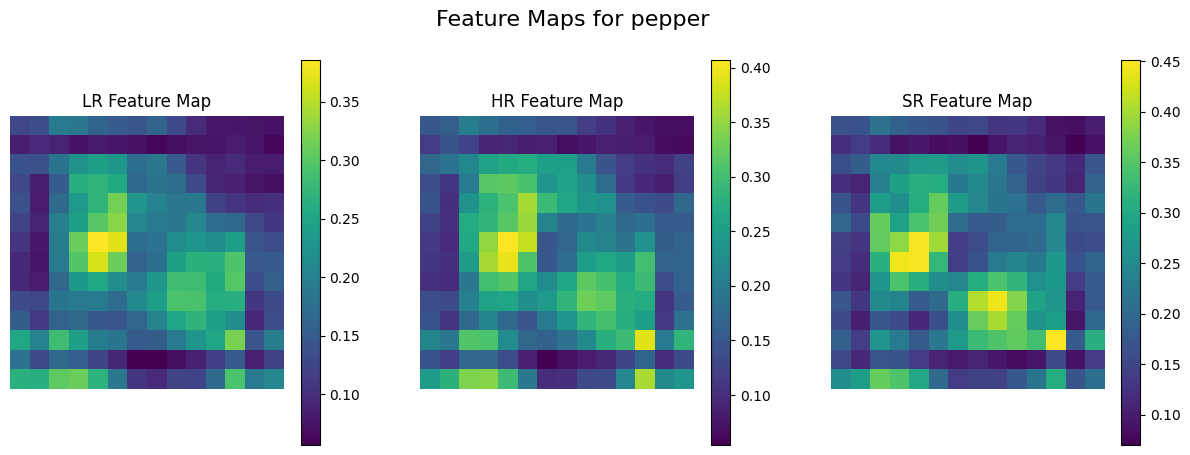

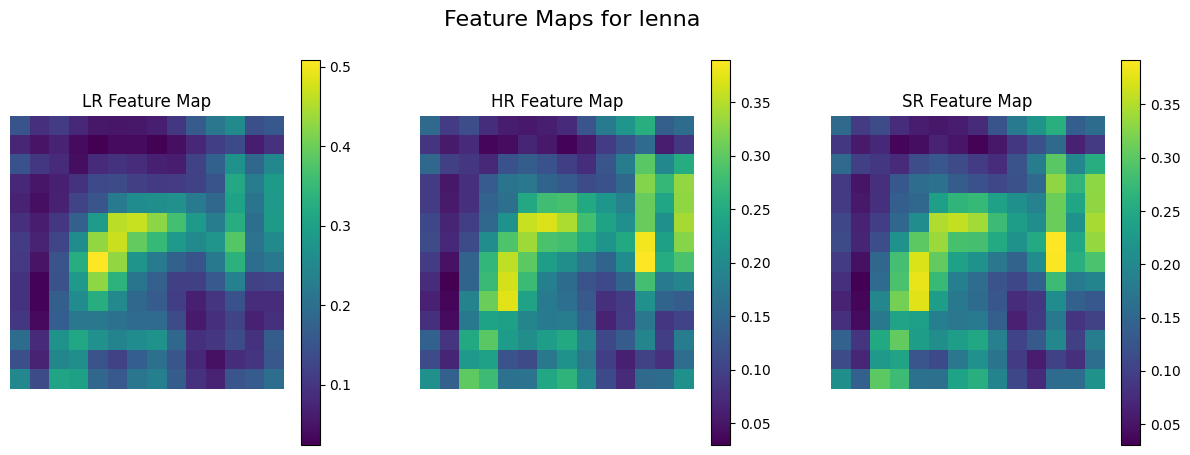

In [125]:
# Set random seed
np.random.seed(120)

# Plot the feature maps
n = len(features.keys()) 

# Get the features list
features_list = list(features.items())

# Plot 5 random feature maps for the LR, HR and SR images
for i in np.random.randint(0, n, 5):
    plot_feature_map(features_list[i])

## 7.5 MSE, PSNR and SSIM on set5(Only MSE Loss)

In [126]:
# Get the index of filename that ends in _GT and form a separate dataframe
set5_df = results_df[results_df['Filename'].str.endswith('_GT')]
# Reset the index
set5_df.reset_index(drop=True, inplace=True)
# Calculate the average PSNR for Set5
avg_psnr_set5 = set5_df['PSNR'].mean()
print(f"Average PSNR for Set5: {avg_psnr_set5:.2f} dB")
set5_df

Average PSNR for Set5: 28.66 dB


,Filename,MSE,PSNR,SSIM
0,butterfly_GT,76.105240,29.316658,0.946400
1,woman_GT,42.673972,31.829173,0.955975
2,head_GT,56.316905,30.624416,0.872966
3,baby_GT,171.258347,25.794286,0.907223
4,bird_GT,173.868968,25.728583,0.962963


## 7.6 MSE, PNSR and SSIM on set14(Only MSE Loss)

In [127]:
# Rest of the files are for Set14
set14_df = results_df[~results_df['Filename'].str.endswith('_GT')]
# Reset the index
set14_df.reset_index(drop=True, inplace=True)
# Calculate the average PSNR
avg_psnr_set14 = set14_df['PSNR'].mean()
print(f"Average PSNR for Set14: {avg_psnr_set14:.2f} dB")
set14_df

Average PSNR for Set14: 24.08 dB


,Filename,MSE,PSNR,SSIM
0,ppt3,5764.095774,10.523492,0.624560
1,coastguard,281.311671,23.638926,0.890242
2,baboon,295.530206,23.424785,0.792686
3,zebra,481.831051,21.301856,0.895512
4,monarch,25.262456,34.106048,0.946534
5,face,56.448475,30.614282,0.873071
6,foreman,278.152998,23.687966,0.895546
7,barbara,105.226208,27.909564,0.879251
8,comic,1012.826013,18.075455,0.831240
9,man,344.208087,22.762593,0.820713


# 9.0 Unpaired Data

## 9.1 Generating Training and Validation with differenet blurring

### Key Parameters:
- **`operation`**: Determines which type of blur to apply. Each has unique characteristics:
    - **`'bilateral'`**: Preserves edges while reducing noise. Useful for simulating images with reduced detail but intact edges.
    - **`'box'`**: Applies a simple averaging filter. It can simulate general loss of detail without specific noise reduction.
    - **`'median'`**: Effective at removing salt-and-pepper noise while preserving edges. It's particularly useful for simulating images that maintain edge integrity but have reduced fine textures.

- **`sigma_color`** and **`sigma_space`** are specific to the bilateral filter. They control how much the filter smoothens color and space (coordinates) dimensions, respectively.

- **`sigma_color`**: This parameter is crucial in the bilateral filter and determines how much the filter influences color intensity. It represents the filter's sensitivity to color differences. The larger the `sigma_color`, the more colors in the neighborhood will be mixed together, leading to a larger area of semi-equal color.

- **`sigma_space`**: This parameter defines the spatial extent of the kernel, that is, how far away (in pixel distance) the influence of a single pixel's intensity value will reach. A larger `sigma_space` means that farther pixels will influence each other as long as their colors are close enough (within the range defined by `sigma_color`).


In [ ]:
import cv2 as cv
import numpy as np
from typing import Tuple

def generate_unpaired_lr_image(image: np.ndarray, operation: str, kernel_size: Tuple[int, int] = (5, 5), sigma_color: float = 75, sigma_space: float = 75) -> np.ndarray:
    """
    Processes the image based on the specified operation: Bilateral Blur, Box Blur, or Median Blur,
    for both grayscale and color images.

    Parameters:
    - image (np.ndarray): The input image to process. Can be grayscale or color.
    - operation (str): The operation to perform - 'bilateral', 'box', 'median'.
    - kernel_size (Tuple[int, int]): The kernel size for blurring. For median blur, only kernel_size[0] is used.
    - sigma_color (float): The sigma value for color space in bilateral filter.
    - sigma_space (float): The sigma value for coordinate space in bilateral filter.

    Returns:
    - np.ndarray: Low-resolution image.
    """
    if operation == 'bilateral':
        # Apply Bilateral Blur
        # Note: Bilateral filtering is applied only with a single parameter for kernel size.
        # We use sigmaColor and sigmaSpace for the bilateral filter.
        d = kernel_size[0]  # Diameter of each pixel neighborhood.
        lr_image = cv.bilateralFilter(image, d, sigma_color, sigma_space)
    elif operation == 'box':
        # Apply Box Blur (Averaging Blur)
        lr_image = cv.blur(image, kernel_size)
    elif operation == 'median':
        # Apply Median Blur
        # Note: Median blur only takes an integer kernel size, and it must be odd.
        # kernel_size[0] is used and ensured to be odd.
        ksize = kernel_size[0] if kernel_size[0] % 2 == 1 else kernel_size[0] + 1
        lr_image = cv.medianBlur(image, ksize)
    else:
        raise ValueError("Unsupported operation specified. Choose 'bilateral', 'box', or 'median'.")
    
    return lr_image

### 9.1.1 Blurring(Unpaired)

In [ ]:
# Hyperparameters for Blurring(Gaussian, Bilateral, Box and Median)
kernel_size = (9, 9)
sigma = 1.5
scale = 3

### 9.1.2 Generating Training Data

In [ ]:
train_data_dir = "../Data/Unpaired/Train/HR"

# Generate unpaired LR images
for filename in tqdm(unpaired_hr_filenames):
    filepath = os.path.join(train_data_dir, filename)
    if os.path.isfile(filepath):
        filename = filename.split('.')[0]
        # Load the image
        img = Image.open(filepath)

        # Convert to numpy array
        img = np.array(img)

        # Generate Low Resolution Image
        lr_img = generate_unpaired_lr_image(img, 'box', kernel_size)

        # Convert the numpy array to PIL image
        lr_img = Image.fromarray(lr_img)

        if not os.path.exists("../Data/Unpaired/Train/UnpairedLR"):
            os.makedirs("../Data/Unpaired/Train/UnpairedLR")
        
        lr_img.save(f"../Data/Unpaired/Train/UnpairedLR/{filename}.png")

### 9.1.3 Generating Validation Data

In [ ]:
validation_data_dir = "../Data/Unpaired/Test/HR"

# Generate unpaired LR images for validation data
for filename in tqdm(os.listdir(validation_data_dir)):
    filepath = os.path.join(validation_data_dir, filename)
    if os.path.isfile(filepath):
        
        filename = filename.split('.')[0]
        # Load the image
        img = Image.open(filepath)

        # Convert to numpy array
        img = np.array(img)

        # Generate Low Resolution Image
        lr_img = generate_lr_image(img, 'blur', scale, kernel_size, sigma)

        # Convert the numpy array to PIL image
        lr_img = Image.fromarray(lr_img)

        if not os.path.exists("../Data/Unpaired/Validation/UnpairedLR"):
            os.makedirs("../Data/Unpaired/Validation/UnpairedLR")
        
        # Save the LR image
        lr_img.save(f"../Data/Unpaired/Validation/UnpairedLR/{filename}.png")

## 9.2 Custom Dataset for Unapaired LR Images

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from torchvision import transforms

# Class for loading Unpaired LR Data
class LRDataset(Dataset):

    def __init__(self, lr_img_dir:str, ext: str, transform=None):
        """
        Initialize the dataset object for LR images.

        Parameters:
        - lr_img_dir (str): Directory containing LR images.
        - ext (str): File extension of the images(e.g., 'jpg', 'png').
        - transform: Transform to apply to the images.
        """

        self.lr_img_paths = sorted(list(Path(lr_img_dir).glob(f"*.{ext}")))
        self.transform = transform
    
    def __len__(self):
        """Return the total number of samples"""
        return len(self.lr_img_paths)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        """Return one sample of data"""
        lr_image_path = self.lr_img_paths[idx]
        lr_image = Image.open(lr_image_path).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
        return lr_image

### 9.2.1 LR Transform

In [ ]:
from torchvision import transforms

# LR Image transform(ToTensor, Normalize, RandomHorizontalFlip, Rotate)
lr_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor()
])

lr_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

### 9.2.2 LR Dataset

In [ ]:
# LR Training dataset
lr_train_dir = '../Data/Unpaired/Train/UnpairedLR'

# LR Validation dataset
lr_val_dir = '../Data/Unpaired/Validation/UnpairedLR'

# Create LR Train and Validation Dataset
lr_train_data_custom = LRDataset(lr_img_dir=lr_train_dir,
                    ext="png",
                    transform=lr_train_transform)

lr_validation_data_custom = LRDataset(lr_img_dir=lr_val_dir,
                    ext="png",
                    transform=lr_val_transform)

lr_train_data_custom, lr_validation_data_custom

### 9.2.3 Turn Custom Dataset into DataLoader

In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32

# Create Dataloade for LR dataset
unpairedlr_train_dataloader_custom = DataLoader(dataset=lr_train_data_custom,
                                                 num_workers=os.cpu_count(),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True)

unpairedlr_validation_dataloader_custom = DataLoader(dataset=lr_validation_data_custom,
                                                     num_workers=os.cpu_count(),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False)

len(unpairedlr_train_dataloader_custom), len(unpairedlr_validation_dataloader_custom)

In [ ]:
img_batch = next(iter(unpairedlr_train_dataloader_custom))

# print out shape
print(f"Image Batch shape: {img_batch.shape} ->[batch_size, color_channel, height, width]")

In [ ]:
img_batch = next(iter(unpairedlr_validation_dataloader_custom))

# print the shape
print(f"Image Batch shape: {img_batch.shape} ->[batch_size, color_channel, height, width]")

## 9.3 Create train and test loop function

* `train_step()` - Takes in model and dataloader and trains the model on the dataloader

* `test_step()` - Take in model and dataloader and evaluatest the model on the dataloader

In [ ]:
import torch
import torchvision.transforms.functional as TF

def train_step2(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               perpetual_loss: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str = "cuda") -> float:

    """
    Function to perform a single training step.

    Parameters:
    - model: The model to train
    - dataloader: The dataloader for the training data
    - perpetual_loss: The perpetual loss function
    - optimizer: The optimizer for the model
    - device: The device to run the computation

    Returns:
    - loss: The training loss

    Raises:
    - AssertionError: If the input parameters are not of the expected typer
    """

    if not isinstance(model, torch.nn.Module):
        raise AssertionError("Model should be an instance of torch.nn.Module")
    if not isinstance(dataloader, torch.utils.data.DataLoader):
        raise AssertionError("Dataloader should be an instance of torch.utils.data.DataLoader")
    if not isinstance(perpetual_loss, torch.nn.Module):
        raise AssertionError("Perpetual loss should be an instance of torch.nn.Module")
    if not isinstance(optimizer, torch.optim.Optimizer):
        raise AssertionError("Optimizer should be an instance of torch.optim.Optimizer")
    

    # Ensure the model is right device
    model.to(device)

    # 1. Set the model in training mode
    model.train()

    # 2. Initialize total loss
    train_loss = 0.0

    # 3. Loop through the dataloader
    for X in dataloader:

        # Move the data to the device
        X = X.to(device)

        # 4.0 Perform Forward pass from model(SRCNN)
        y_pred = model(X)

        # 5.0 Ensure model(SRCNN) ouptut matches VGG19 input expectation i.e. size: (224, 224) + Normalize + Tensor
        # If Padding = 'same' then input and output size same else output size = input size - kernel_size + 1
        # Resize if necessary
        if y_pred.shape[2:] != (224, 224):
            y_pred = TF.resize(y_pred, size=(224, 224))

        # Normalize
        y_pred = TF.normalize(y_pred, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        # 6.0 Compute the perpetual loss(No need to compute the features of y_pred as it is already taken care in perpetual loss)
        loss = perpetual_loss(y_pred)

        # 7.0 Zero the gradients
        optimizer.zero_grad()

        # 8.0 Perform Backward pass
        loss.backward()

        # 9.0 Update the weights
        optimizer.step()

        # 10.0 Update the total loss
        train_loss += loss.item()

    # Adjust the loss per batch
    train_loss /= len(dataloader)

    return train_loss


In [ ]:
import torch
import torchvision.transforms.functional as TF

def test_step2(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              perpetual_loss: torch.nn.Module,
              device: str = 'cuda') -> float:
    
    """
    Function to perform Validation step for unpaired data.

    Parameters:
    - model: Pretrained SRCNN model for fine tuning
    - dataloader: Dataloader for the unpaired LR images
    - perpetual_loss_fn: Perpetual loss function
    - device: Device to run the computation

    Return:
    - float: Loss for the current step

    Raises:
    - AssertionError: If the input parameters are not of the expected type
    """

    if not isinstance(model, torch.nn.Module):
        raise AssertionError("model should be an instance of torch.nn.Module")
    if not isinstance(dataloader, torch.utils.data.DataLoader):
        raise AssertionError("dataloader should be an instance of torch.utils.data.DataLoader")
    if not isinstance(perpetual_loss, torch.nn.Module):
        raise AssertionError("perpetual_loss should be an instance of torch.nn.Module")
    if not isinstance(device, str):
        raise AssertionError("device should be a string")
    
    # Ensure the models is on right device
    model = model.to(device)

    # 1.0 Set the model to evaluation mode
    model.eval()

    # 2.0 Initialize the total loss
    total_loss = 0.0

    with torch.inference_mode():
        
        # 3.0 Loop through the dataloader
        for X in dataloader:
            
            # Move the data to the right device
            X = X.to(device)

            # 4.0 Forward pass through model(SRCNN)
            with torch.inference_mode():
                y_pred = model(X)

            # 5.0 Ensure model(SRCNN) ouptut matches VGG19 input expectation i.e. size: (224, 224) + Normalize + Tensor
            # If Padding = 'same' then input and output size same else output size = input size - kernel_size + 1
            # Resize if necessary
            if y_pred.shape[2:] != (224, 224):
                y_pred = TF.resize(y_pred, size=(224, 224))

            # Normalize
            y_pred = TF.normalize(y_pred, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 
            # 6.0 Compute the perpetual loss(No need to compute the features of y_pred as it is already taken care in perpetual loss)
            loss = perpetual_loss(y_pred)

            # 7.0 Update the total loss
            total_loss += loss.item()
    
    # 8.0 Adjust the metrics per batch
    total_loss /= len(dataloader)

    return total_loss

## 9.4 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
import os
import time
from tqdm.auto import tqdm

def train2(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          perpetual_loss: torch.nn.Module,
          path: str,
          start_epoch: int = 1, 
          end_epoch: int = 150, 
          checkpoint_interval=20,
          device: str = device):

  # 1.0 Start the timer
  start_time = time.time()

  # 2.0 Initialize the results dictionary
  results = {'train_loss': [],
             'val_loss': []}

  # 3.0 Directory to save the model
  if not (os.path.exists("/home/mpershad/Documents/Python/SRCNN/Models/SRCNN_VGG")):
    os.makedirs("/home/mpershad/Documents/Python/SRCNN/Models/SRCNN_VGG")

  model_path = f"/home/mpershad/Documents/Python/SRCNN/Models/SRCNN_VGG/{path}.pth"

  # 4.0 Initialize the Early Stopping
  early_stopper = EarlyStopping(patience=30, verbose=True, delta=5e-6, path=model_path)

  # 5.0 Calculate Logging interval(10% of total)
  total_epochs = end_epoch - start_epoch
  log_interval = total_epochs // 10 if total_epochs // 10 > 0 else 1
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(start_epoch, end_epoch)):

    # 6.0 Training Step
    train_loss = train_step2(model=model,
                             dataloader=train_dataloader,
                             perpetual_loss=perpetual_loss,
                             optimizer=optimizer,
                             device=device)
    
    # 7.0 Testing Step(Validation)
    val_loss = test_step2(model=model,
                                  dataloader=test_dataloader,
                                  perpetual_loss=perpetual_loss,
                                  device=device)

    # 8.0 Append the results to the dictionary
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)    

    # Log PSNR values
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})

    # Log values every 10% of the total epochs
    if epoch % log_interval == 0 or epoch == end_epoch - 1:
      
      # Print out what's happening
      print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # 9.0 Check for early stopping
    early_stopper(val_loss, model, optimizer)
    if early_stopper.early_stop:
        print("Early stopping")
        break

    # 10.0 Checkpoint saving
    if epoch % checkpoint_interval == 0 or epoch == end_epoch - 1:
      checkpoint_path = f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/SRCNN_VGG/{path}/epoch_{epoch}.pth"

      if not (os.path.exists(f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/SRCNN_VGG/{path}")):
        os.makedirs(f"/home/mpershad/Documents/Python/SRCNN/Checkpoints/SRCNN_VGG/{path}")

      save_checkpoint(epoch=epoch, model=model, optimizer=optimizer, loss=train_loss, path=checkpoint_path)
      # Optionally log checkpoint to wandb
      # checkpoint_path_wandb = f"SRCNN_VGG/Checkpoints/SRCNN_VGG/{path}/epoch_{epoch}.pth"
      wandb.save(checkpoint_path, base_path="/home/mpershad/Documents/Python/SRCNN/Checkpoints/SRCNN_VGG")

  # 11.0 Use wandb.save() to ensure the model file is saved to W&B
  # model_path_wandb = f"SRCNN_VGG/Models/SRCNN_VGG/{path}.pth"
  wandb.save(model_path, base_path="/home/mpershad/Documents/Python/SRCNN/Models/SRCNN_VGG")

  # 12.0 Log the model as an artifact
  artifact = wandb.Artifact('SRCNN_VGG', type='model', description="A super-resolution model")
  artifact.add_file(model_path)
  wandb.log_artifact(artifact)

  # 13.0 Calculate and log training duration
  end_time = time.time()
  total_training_time = end_time - start_time
  wandb.log({'total_training_time': total_training_time})

  print(f"Total training time: {total_training_time:.3f} seconds")

  # 14.0 Remember to finish the W&B run
  wandb.finish()

  return results

# 10.0 Tracking Expirements(SRCNN + VGG)

* Option 1: Loading pretrained model and continue training
* Option 2: One large training routine

In [ ]:
# Update the config for fine tunning using perpetual loss 
# SRCNN Model itself remains the same in terms of input_channels, output_channels, architecture, learning rate of the optimizer
# Need to change the number of epochs, checkpoint interval, loss function

wandb.init(project="SRCNN+VGG", entity="pershadmayank", config={
    'start_epoch': 1,
    'end_epoch': 500,
    'checkpoint_interval': 100
})

## 10.1 Setup Loss function

In [ ]:
model_name = str(input("Enter model name:"))

In [ ]:
# Access hyperparameters from wandb.config
config = wandb.config

# Initialize the perpetual loss
perpetual_loss = PerpetualLoss(hr_avg_features)

# Train the model
model_results2 = train2(model=model,
                      train_dataloader=unpairedlr_train_dataloader_custom,
                      test_dataloader=unpairedlr_validation_dataloader_custom,
                      perpetual_loss=perpetual_loss,
                      optimizer=optimizer,
                      path=model_name,
                      start_epoch=config.start_epoch,
                      end_epoch=config.end_epoch,
                      device=device)

## 10.2 Save the results Dictionary

In [ ]:
import pickle
import os

metrics_path = f'../Metrics/SRCNN_VGG'

if not os.path.exists(metrics_path):
  os.makedirs(metrics_path)

pickle_file_path = os.path.join(metrics_path, f"metrics_{model_name}.pkl")

with open(pickle_file_path, 'wb') as file:
    pickle.dump(model_results2, file)

print(f"Results saved to {pickle_file_path}")

In [ ]:
plot_loss_curves(model_results2)

# 11.0 Loading Fine Tuned Model

In [ ]:
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
import os

# Set the API key
os.environ['WANDB_API_KEY'] = '0736c590933a18ad9639f49867ed1548495ded1c'

## 11.1 Log In

In [ ]:
import wandb

# Initialize W&B web client
api = wandb.Api()

## 11.2 Connect to the specific project run

In [ ]:
# Define the wandb entity and project
project_name = "SRCNN+VGG"  # replace with your wandb project name
entity_name = "pershadmayank"  # replace with your wandb entity
run_id = input("Enter runtime ID: ")  # replace with the run ID you want to download from

# Get the specific run
run = api.run(f"{entity_name}/{project_name}/{run_id}")

In [ ]:
# Get the artifact using the API
artifact = api.artifact("pershadmayank/SRCNN+VGG/SRCNN_VGG:v2", type="model")

# Use the artifact in your current run
run = wandb.init()
artifact_obj = run.use_artifact(artifact)

# Download the artifact's contents
artifact_dir = artifact_obj.download()

In [ ]:
import os
import glob

# Assuming artifact_dir is the directory where the artifact is downloaded
model_path = glob.glob(os.path.join(artifact_dir, "*.pth"))

if not model_path:
    raise FileNotFoundError("No .pth file found in the artifact directory.")

model_path[0]

In [ ]:
# Load the checkpoint
checkpoint = torch.load(model_path[0], map_location=device)  # or 'cuda' if using GPU

# Apply the loaded state dictionaries to the model and optimizer
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model to the desired device
model.to(device)

# 12.0 Inference using trained Model 2

In [ ]:
# /content/SRCNN/Data/Test/LR/lenna.bmp
# test_img_path = input("Enter Image Path: ")
test_img_path = "../Data/Unpaired/Test/HR/lenna.bmp"

In [ ]:
lr_img, img, pred_img = pred_and_plot_image(model=model,  # Replace with your model variable
                                image_path=test_img_path,  # Replace with the path to your image
                                lr_image=generate_unpaired_lr_image,  # The function to generate LR image
                                lr_image_args={'operation': 'box', 'kernel_size': kernel_size},  # Arguments for the LR image function
                                transform=test_img_transform,  # The transformation to apply
                                device=device,  # The device (cpu or cuda)
                                plot=True)

## 12.1 Feature extraction using VGG19 

In [ ]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Create dictionary to store the metrics
metrics_dict = {'Filename': [], 'MSE': [], 'PSNR': [], 'SSIM': []}

# Tansform for preforming same preprocessing as VGG19 before extracting features
vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initalize VGG19 feature extractor
vgg19 = VGG19FeatureExtractor().to(device)

# Store LR, HR and SR features with filename as key
features = {}

# Apply the above transform to all the images in test set
test_img_dir = "../Data/Unpaired/Test/HR"
for f in tqdm(os.listdir(test_img_dir)):
    
    img_path = os.path.join(test_img_dir, f)

    # Get the filename
    filename = f.split('.')[0]

    lr_img, img, pred_img = pred_and_plot_image(model=model,  # Replace with your model variable
                                    image_path=img_path,  # Replace with the path to your image
                                    lr_image=generate_unpaired_lr_image,  # The function to generate LR image
                                    lr_image_args={'operation': 'box', 'kernel_size': kernel_size},  # Arguments for the LR image function
                                    device=device,  # The device (cpu or cuda)
                                    plot=False)
    # Get the metrics
    metrics = combined_metric(img, pred_img)

    # Update the dictionary
    metrics_dict['Filename'].append(filename)
    metrics_dict['MSE'].append(metrics[0])
    metrics_dict['PSNR'].append(metrics[1])
    metrics_dict['SSIM'].append(metrics[2])

    # Convert PIL images to tensors and preprocess for VGG19
    lr_img_tensor = vgg_transform(Image.fromarray(lr_img)).unsqueeze(0)
    img_tensor = vgg_transform(Image.fromarray(img)).unsqueeze(0)
    pred_img_tensor = vgg_transform(Image.fromarray(pred_img)).unsqueeze(0)

    # Extract features of shape [C, H, W] 
    lr_features = vgg19(lr_img_tensor.to(device)).detach().cpu().numpy()
    img_features = vgg19(img_tensor.to(device)).detach().cpu().numpy()
    pred_img_features = vgg19(pred_img_tensor.to(device)).detach().cpu().numpy()

    # Update the features dictionary
    features[filename] = {'LR': lr_features, 'HR': img_features, 'Predicted': pred_img_features}

# Flatten the corresponding LR, HR and SR features and stack 
lr_features_flatten = np.stack([features[filename]['LR'].flatten() for filename in features])
hr_features_flatten = np.stack([features[filename]['HR'].flatten() for filename in features])
pred_img_features_flatten = np.stack([features[filename]['Predicted'].flatten() for filename in features])

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(metrics_dict)

## 12.2 TSNE Plot of VGG Features for LR, HR and SR

In [ ]:
%%capture
from sklearn.manifold import TSNE

# stack all the features for TSNE
all_features = np.vstack([lr_features_flatten, hr_features_flatten, pred_img_features_flatten])

# q: Do we need to flatten the features after stacking them?
# a: No, we don't need to flatten the features after stacking them. The features are already flattened.

# Apply TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(all_features)

In [ ]:
plt.figure(figsize=(8, 6))

# Colors and labels for each category
colors = ['blue', 'green', 'red']
category_labels = ['LR', 'HR', 'SR']
n = len(lr_features_flatten)  # Number of images per category

# Plot points and label them with numbers
for i in range(3*n):
    category = i // n  # Determine the category of the current point
    plt.scatter(tsne_features[i, 0], tsne_features[i, 1], color=colors[category], alpha=0.5)
    # Add a numerical label near each point
    plt.text(tsne_features[i, 0], tsne_features[i, 1], str(i % n), fontsize=8, ha='right', va='bottom')

# Create custom legend handles
from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=l)
                  for c, l in zip(colors, category_labels)]

plt.title('TSNE Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# Add the custom legend to the plot
plt.legend(handles=legend_handles, title="Categories")
plt.show()

## 12.3 MSE, PSNR and SSIM on set5(Only MSE Loss)

In [ ]:
# Get the index of filename that ends in _GT and form a separate dataframe
set5_df = results_df[results_df['Filename'].str.endswith('_GT')]
# Reset the index
set5_df.reset_index(drop=True, inplace=True)
# Calculate the average PSNR for Set5
avg_psnr_set5 = set5_df['PSNR'].mean()
print(f"Average PSNR for Set5: {avg_psnr_set5:.2f} dB")
set5_df

## 12.4 MSE, PNSR and SSIM on set14(Only MSE Loss)

In [ ]:
# Rest of the files are for Set14
set14_df = results_df[~results_df['Filename'].str.endswith('_GT')]
# Reset the index
set14_df.reset_index(drop=True, inplace=True)
# Calculate the average PSNR
avg_psnr_set14 = set14_df['PSNR'].mean()
print(f"Average PSNR for Set14: {avg_psnr_set14:.2f} dB")
set14_df